# CDMS Air Quality Match Up Demo
Cloud-based Data Matchup Service (CDMS) allows users to collocate satellite to in situ and satellite to satellite data. 

This notebook illustrates data match-up using datasets relevant to the study of air quality (AQ).

In [19]:
import requests
import json
import pandas as pd
import geopandas as gpd
from urllib.parse import urljoin, urlencode
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import xarray as xr
from IPython.display import JSON

import cdms_reader

## Run satellite to satellite matchup query

Match Up of VIIRS Aerosol Data with MDOIS Aerosol Data for CA 2021 Dixie Fire


In [20]:
matchup_url = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus/match_spark'

In [21]:
def execute_matchup_request(query_params, in_situ_variable_name=None):
    full_matchup_url = f'{matchup_url}?{urlencode(query_params)}'
    print(full_matchup_url)
    
    response = requests.get(full_matchup_url)
    response = response.json()
    
    primary_points = []
    secondary_points = []
    for primary_point in response['data']:
        for variable in primary_point['matches'][0]['secondary']:
            if in_situ_variable_name:
                if variable['variable_name'] == in_situ_variable_name:
                    primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                    secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
            else:
                # pick the first variable
                primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
                break
    print(f'Total number of primary matched points {len(primary_points)}')
    print(f'Total number of secondary matched points {len(secondary_points)}')
    return primary_points, secondary_points, response['executionId']

In [22]:
query_params = {
    'primary': 'laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean',
    'secondary': 'MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean',
    'startTime': '2021-08-07T00:00:00Z',
    'endTime': '2021-08-09T00:00:00Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 18750,  # Spatial tolerance in meters
    'b': '-125,35,-115,45',
    'platforms': '30',
    'depthMin': -1,
    'depthMax': 1,
    'matchOnce': 'true',
    'resultSizeLimit': 0,
    'prioritizeDistance': 'true'
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/match_spark?primary=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&secondary=MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean&startTime=2021-08-07T00%3A00%3A00Z&endTime=2021-08-09T00%3A00%3A00Z&tt=43200&rt=18750&b=-125%2C35%2C-115%2C45&platforms=30&depthMin=-1&depthMax=1&matchOnce=true&resultSizeLimit=0&prioritizeDistance=true
Total number of primary matched points 262
Total number of secondary matched points 262


In [23]:
def fetch_result(execution_id, output_format, output_file, primary_variable, secondary_variable):
    match_up_results_csv = f'{output_file}.csv'
    response = requests.get("https://ideas-digitaltwin.jpl.nasa.gov/nexus/cdmsresults", params={"id": execution_id, "output": output_format})
    with open(output_file, mode='wb') as f:
        f.write(response.content)

    matches = cdms_reader.assemble_matches(output_file)

    cdms_reader.matches_to_csv(matches, match_up_results_csv)
    
    columns_to_include = ["PrimaryData_lon", "PrimaryData_lat", "PrimaryData_datetime", "SecondaryData_lon", "SecondaryData_lat", "SecondaryData_datetime"]
    for variable in primary_variable:
        columns_to_include.append(f'PrimaryData_{variable}')
    for variable in secondary_variable:
        columns_to_include.append(f'SecondaryData_{variable}')
    return pd.read_csv(match_up_results_csv, usecols=columns_to_include)

In [24]:
df = fetch_result(execution_id, "NETCDF", "aerosol_results.nc", ["Aerosol_Optical_Thickness_550_Land_Ocean_Mean"], ["Aerosol Optical Depth"])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_Aerosol_Optical_Thickness_550_Land_Ocean_Mean,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_Aerosol Optical Depth,SecondaryData_datetime
0,-121.5,40.5,3.149284,2021-08-07 00:00:00,-121.5,40.5,2.803,2021-08-07 00:00:00
1,-115.5,41.5,0.026171,2021-08-07 00:00:00,-115.5,41.5,0.021,2021-08-07 00:00:00
2,-118.5,37.5,0.071134,2021-08-08 00:00:00,-118.5,37.5,0.027,2021-08-08 00:00:00
3,-118.5,43.5,0.125071,2021-08-09 00:00:00,-118.5,43.5,0.183,2021-08-09 00:00:00
4,-120.5,37.5,0.060639,2021-08-09 00:00:00,-120.5,37.5,0.184,2021-08-09 00:00:00
...,...,...,...,...,...,...,...,...
257,-122.5,37.5,0.496495,2021-08-07 00:00:00,-122.5,37.5,0.891,2021-08-07 00:00:00
258,-116.5,35.5,0.073865,2021-08-09 00:00:00,-116.5,35.5,0.028,2021-08-09 00:00:00
259,-119.5,35.5,0.266709,2021-08-08 00:00:00,-119.5,35.5,0.408,2021-08-08 00:00:00
260,-115.5,43.5,0.085722,2021-08-09 00:00:00,-115.5,43.5,0.061,2021-08-09 00:00:00


In [25]:
def generate_plot(df, type, variable, units):
    diffs = df[f'{type}_{variable}']
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min(df[f'{type}_lon'])
    max_lon = max(df[f'{type}_lon'])
    min_lat = min(df[f'{type}_lat'])
    max_lat = min(df[f'{type}_lat'])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 15,
        urcrnrlat=max_lat + 15,
        llcrnrlon=min_lon - 15,
        urcrnrlon=max_lon + 15
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    #x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap(df[f'{type}_lon'], df[f'{type}_lat'])

    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    cb = plt.colorbar(sc)
    cb.ax.set_title(units,fontsize=8)        
    plt.title(f'Plot of {variable}')

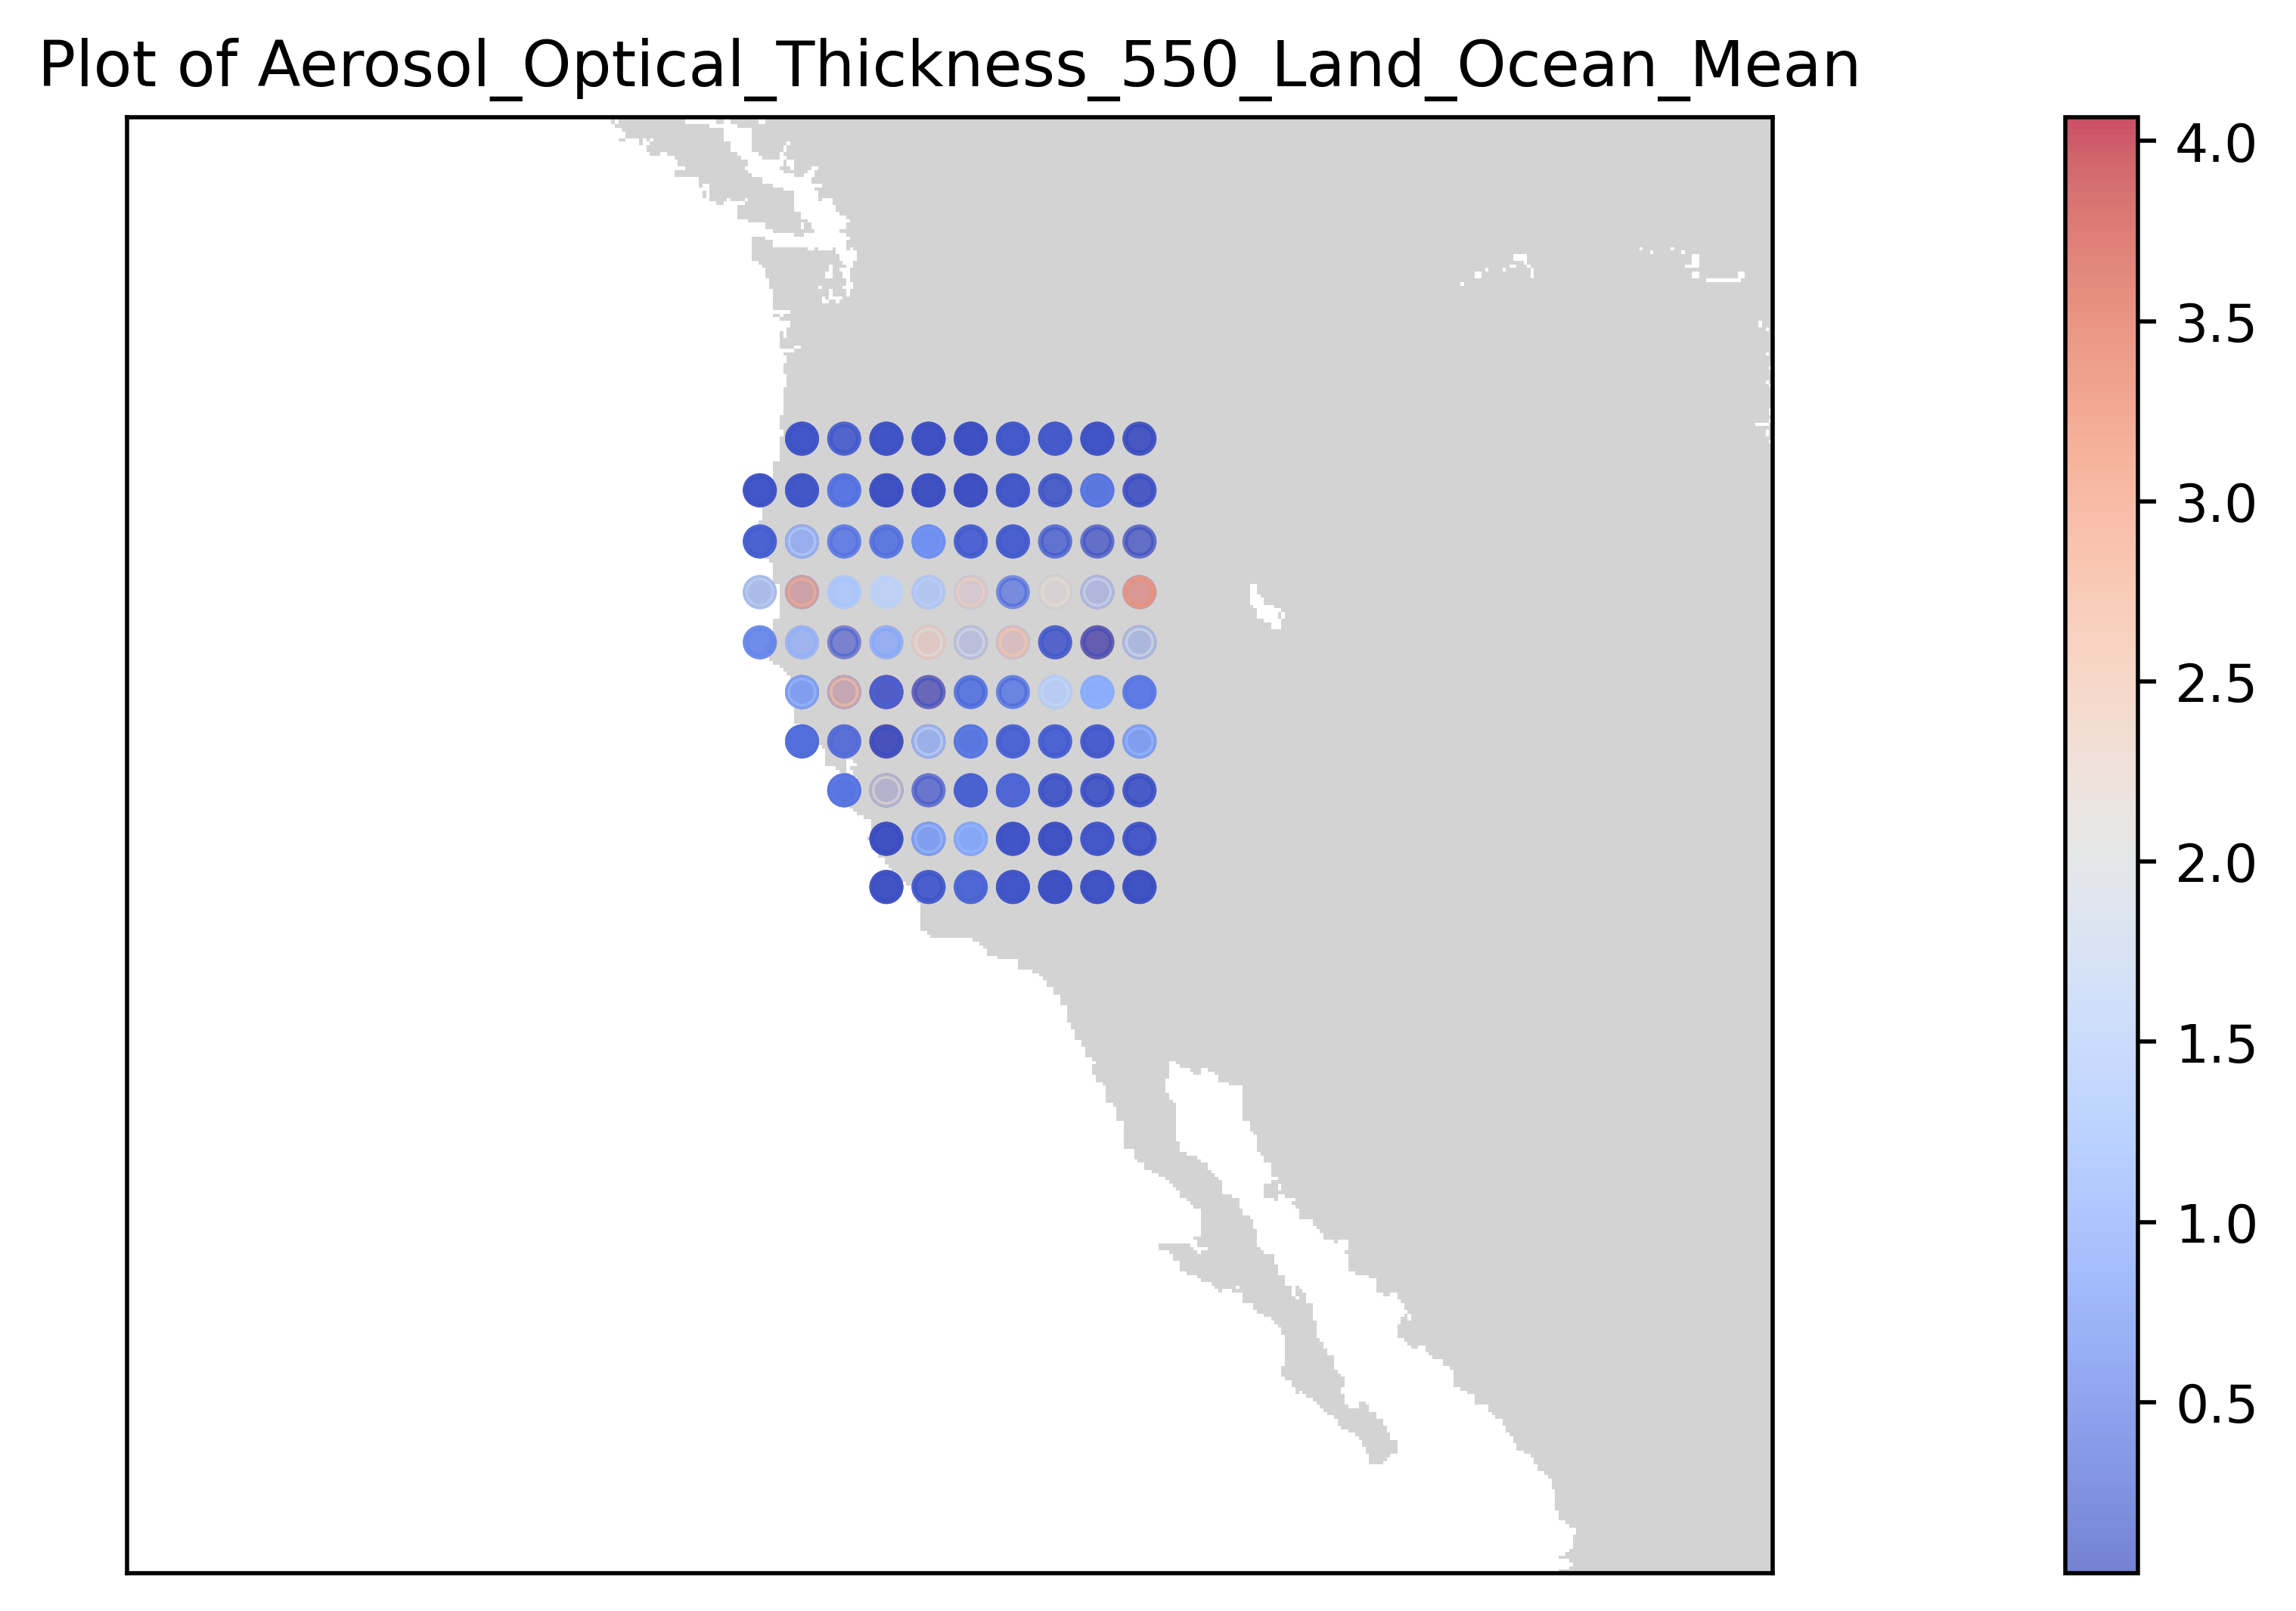

In [26]:
generate_plot(df, "PrimaryData", "Aerosol_Optical_Thickness_550_Land_Ocean_Mean", "")

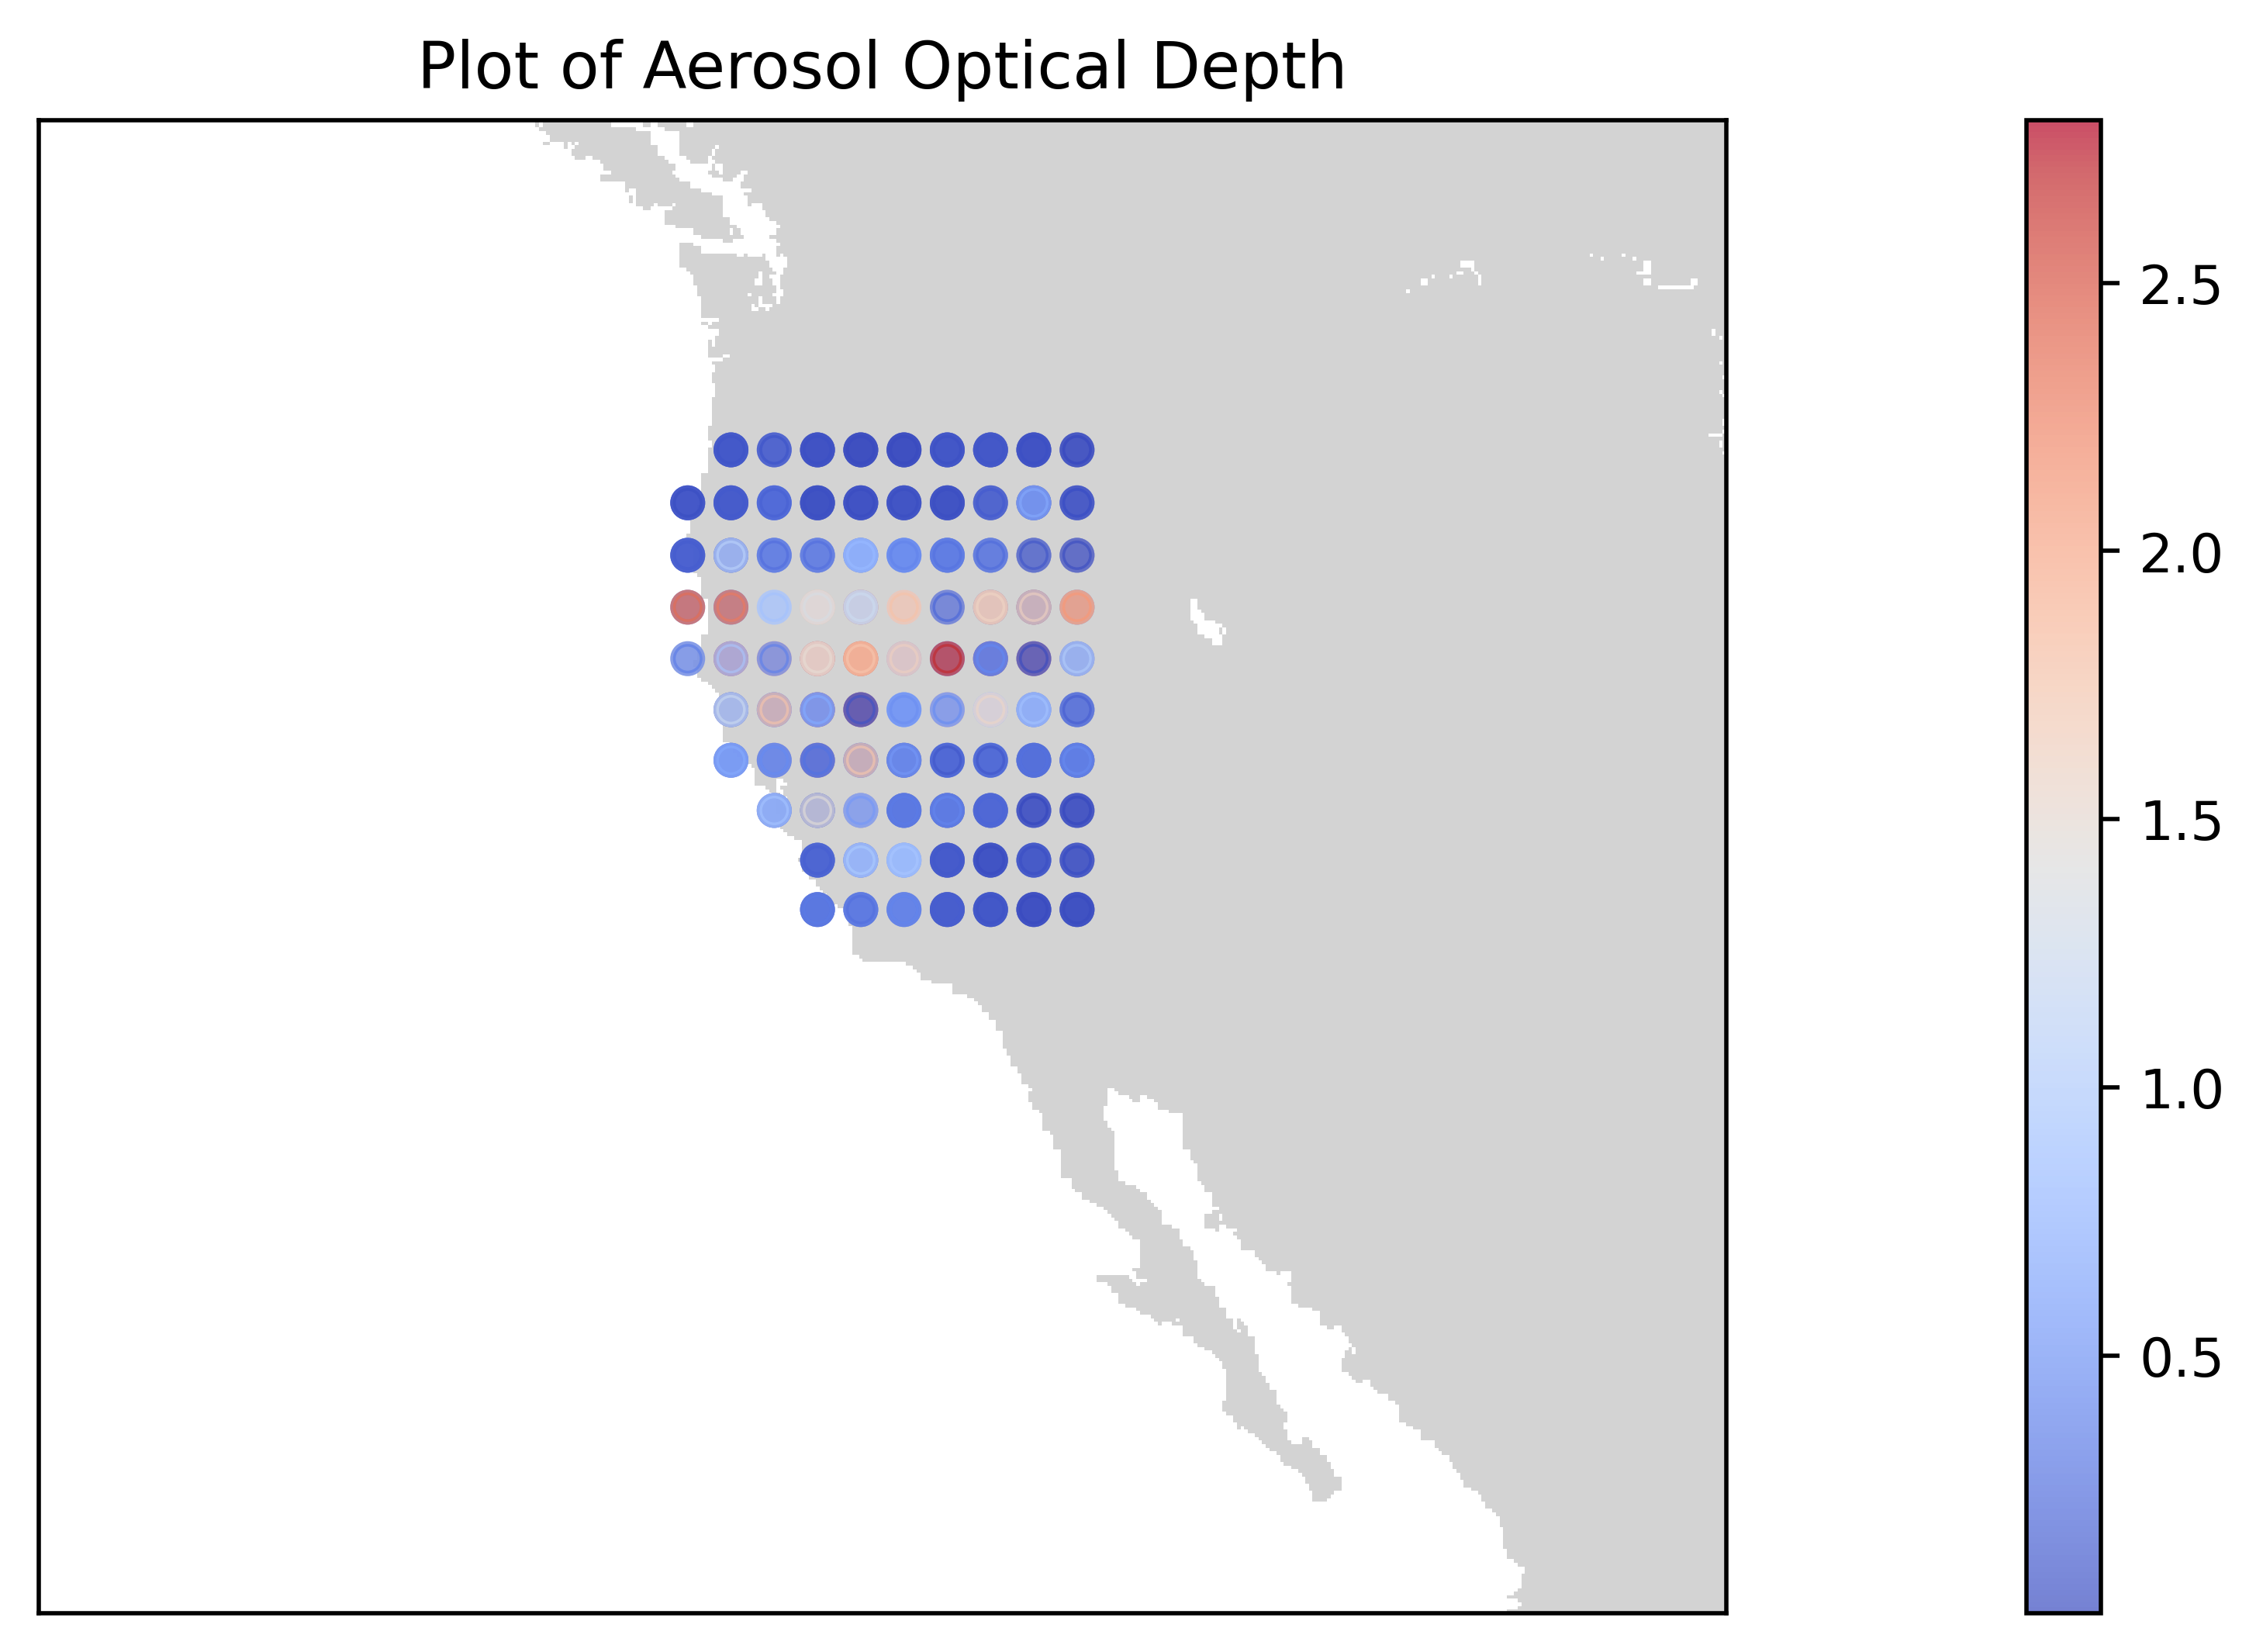

In [27]:
generate_plot(df, "SecondaryData", "Aerosol Optical Depth", "")

In [28]:
def generate_diff_plot(primary_points, secondary_points, primary_name, secondary_name, units):
    diffs = [primary_point[2] - secondary_point[2] for primary_point, secondary_point in zip(primary_points, secondary_points)]
    
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 15,
        urcrnrlat=max_lat + 15,
        llcrnrlon=min_lon - 15,
        urcrnrlon=max_lon + 15
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    cb = plt.colorbar(sc)
    cb.ax.set_title(units,fontsize=8)        
    plt.title(f'Difference plot between VIIRS Aerosol Optical Thickness and MODIS Aerosol Optical Depth')

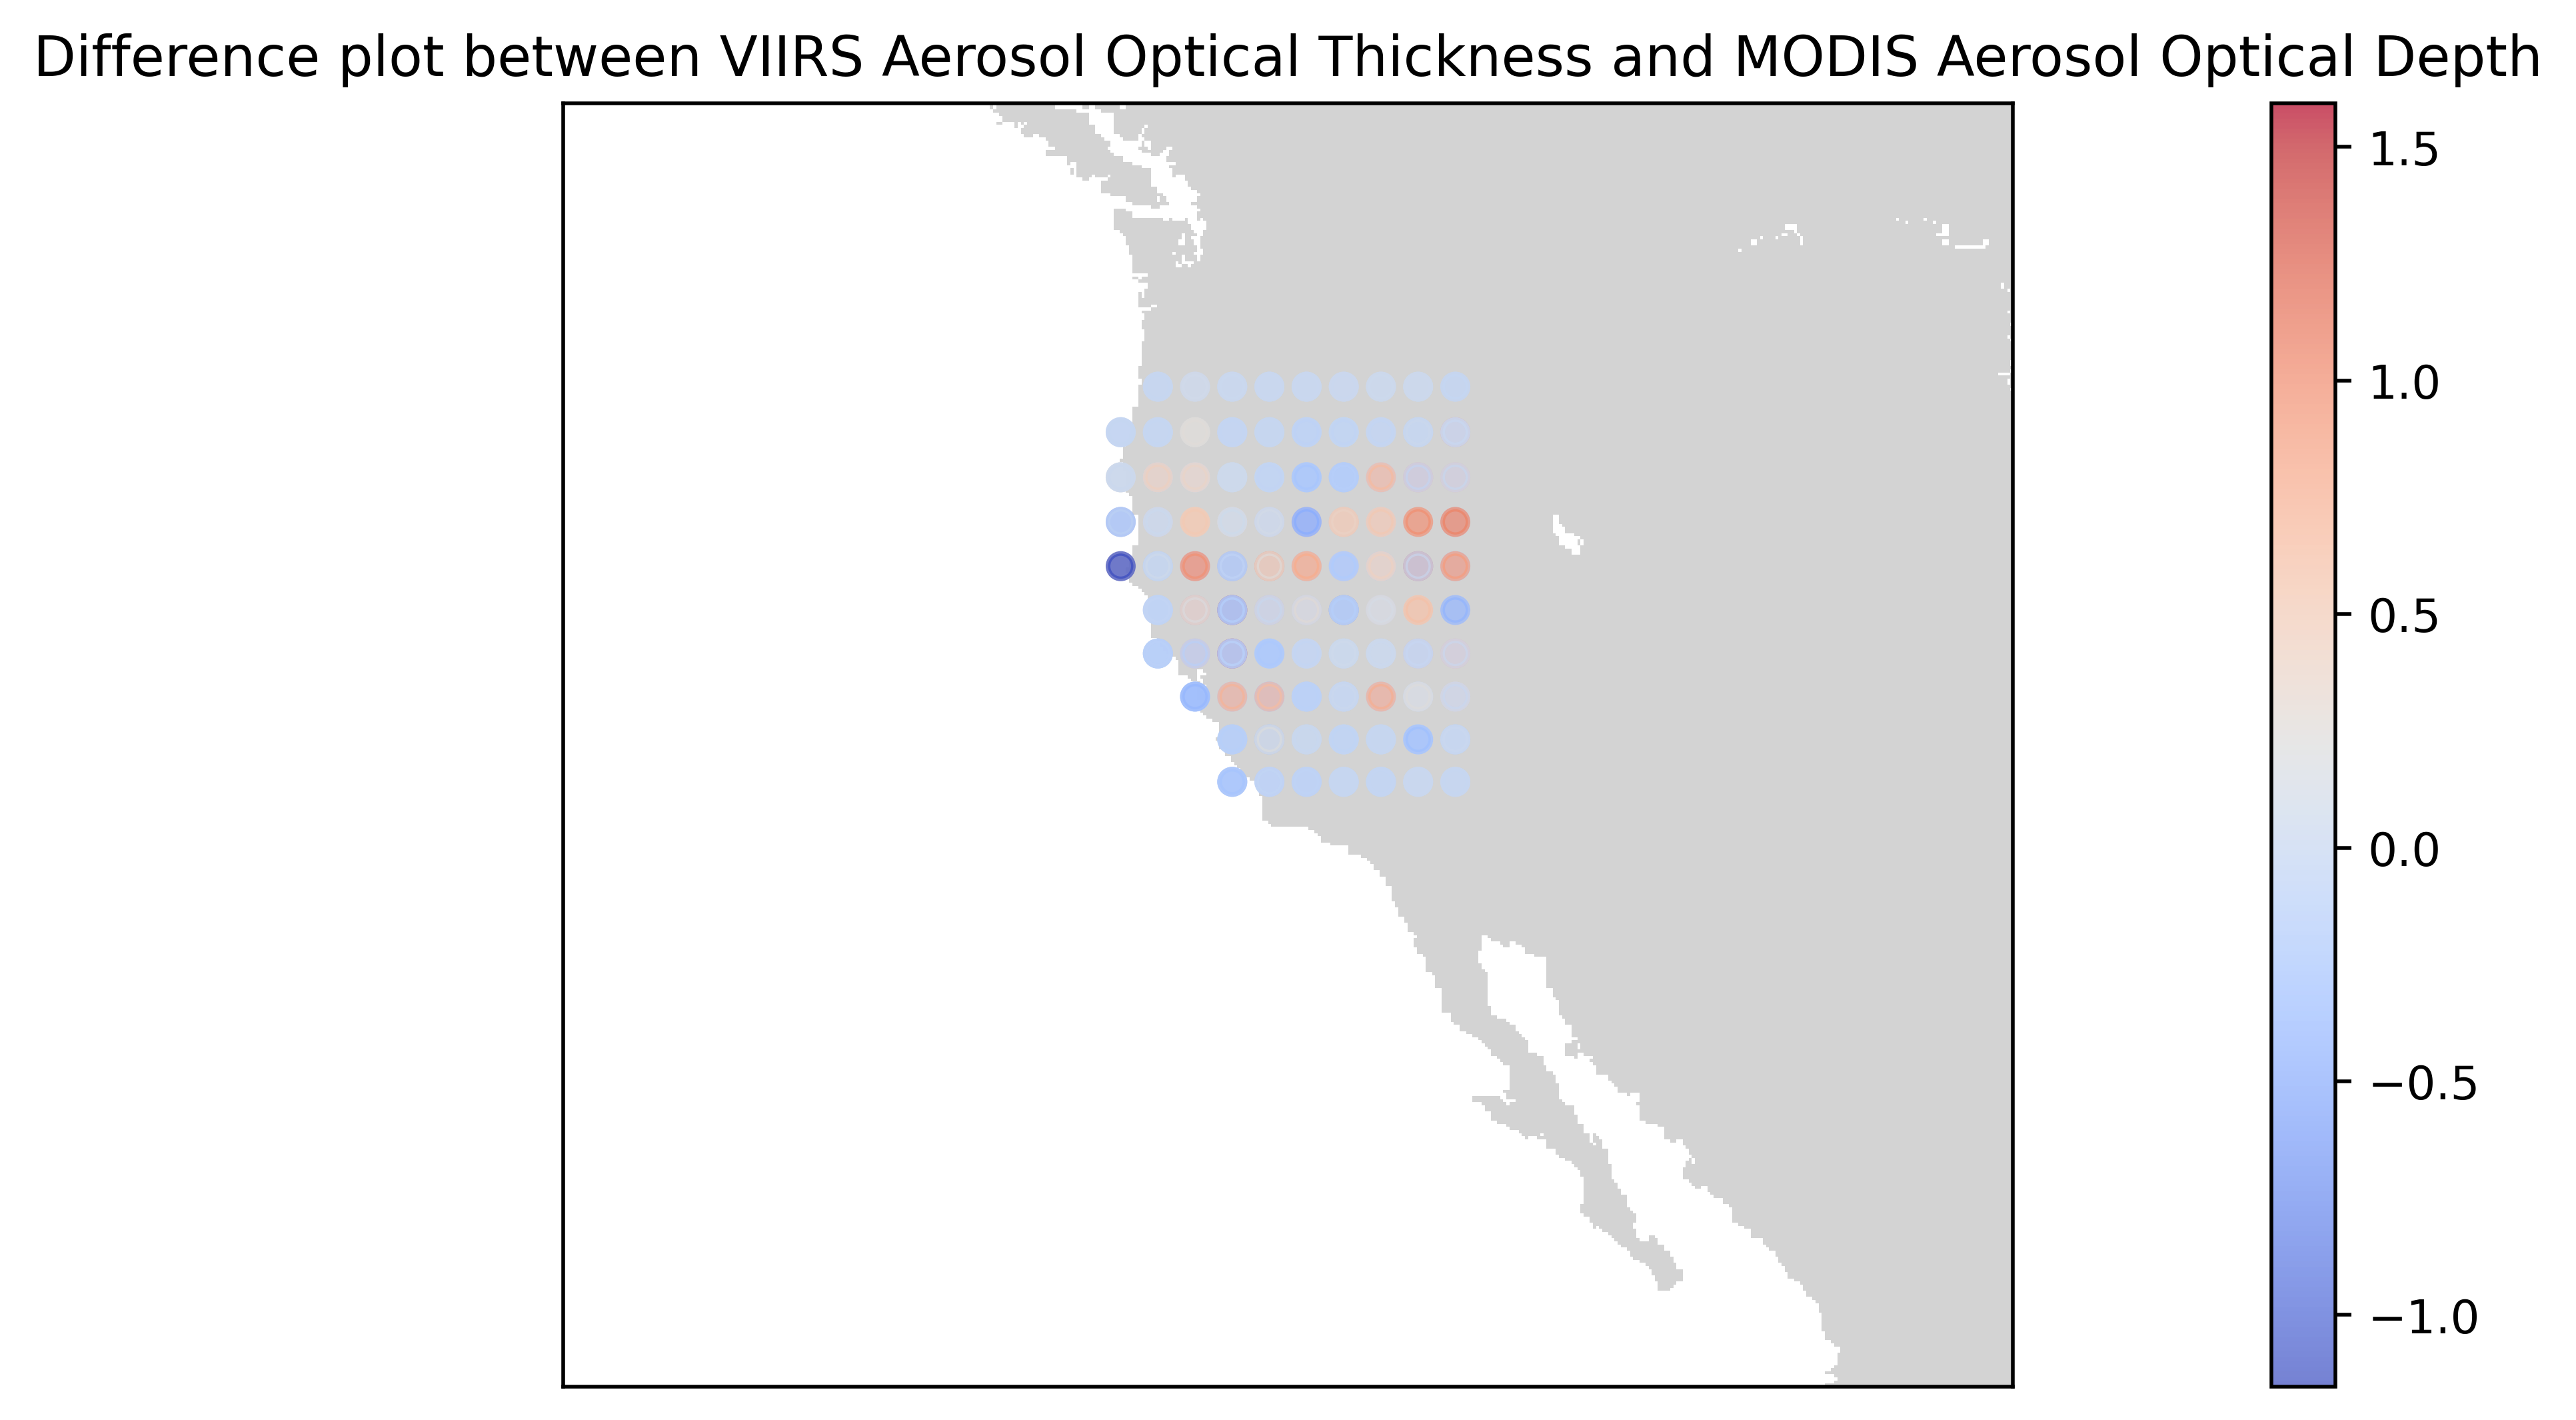

In [29]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], '')

In [30]:
def generate_scatter_plot(primary_points, secondary_points, primary_name, secondary_name, variable_name, units):
    x = np.array([point[2] for point in secondary_points])
    y = np.array([point[2] for point in primary_points])
    m, b = np.polyfit(x, y, 1)
    fig, ax = plt.subplots()
    ax.set_title(f'Aerosol Optical Depth scatter\nVIIRS vs. MODIS')
    ax.set_xlabel("%s %s" % ("MODIS", ""))
    ax.set_ylabel("%s %s" % ("VIIRS", ""))
    ax.scatter(x, y)
    ax.plot(x, m*x+b);
    ax.plot([0,1],[0,1], transform=ax.transAxes)

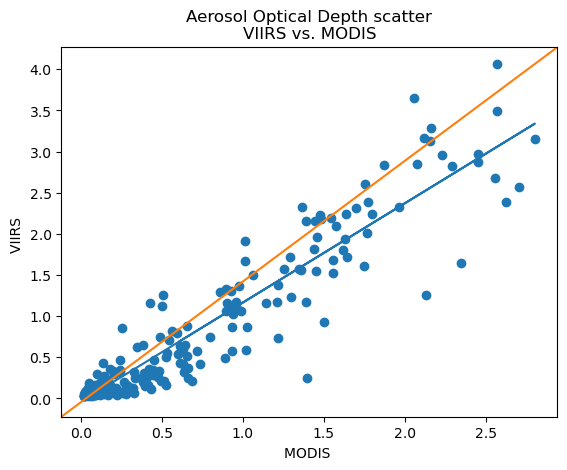

In [31]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], "", '°C')